In [99]:
import numpy as np
import pandas as pd
import keras
from keras import backend as K
from keras.preprocessing import image
from keras.applications.vgg19 import decode_predictions
from keras.models import Sequential, Model
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from glob import glob
import os.path
import PIL

import re
from collections import defaultdict, namedtuple

In [111]:
pd.set_option('display.max_columns', None)

In [2]:
def get_classes(path):
    directories = glob(os.path.expanduser(path) + '/*')
    return [dir.split('/')[-1] for dir in directories]
n_classes =  len(get_classes('~/p5/data/interim/train'))
n_classes

50

In [79]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if ims.shape[-1] != 3:
            ims = ims.transpose((0,2,3,1))
        f = plt.figure(figsize=figsize)
        cols = len(ims) // rows if len(ims) % 2 == 0 else len(ims) // rows + 1
        for i in range(len(ims)):
            sp = f.add_subplot(rows, cols, i + 1)
            sp.axis('Off')
            if titles is not None:
                sp.set_title(title[i], fontsize=16)
            plt.imshow(ims[i], interpolation=None if interp else 'none')

In [97]:
def mk_one_hot_dict(path):
    glyphs = {}
    files = glob(os.path.expanduser(path + '/*'))
    for name in files:
        glyph_name = name.split('/')[-1]
        glyphs[glyph_name] = []
    return glyphs
glyph_dict = mk_one_hot_dict('~/p5/data/interim/train')

In [100]:
def fill_dict(path, dictionary):
    files = glob(os.path.expanduser(path + '/**/*/*'))
    for name in files:
        glyph = re.search(r'/([A-Z]{1}\d+)/', name).group(1)
        dictionary[glyph].append(name)
    return dictionary
# fill_dict('~/p5/data/interim', glyph_dict)

In [121]:
gf = pd.DataFrame(glob(os.path.expanduser('~/p5/data/interim/**/*/*')), columns=['filename'])
gf['set'] = gf.apply(lambda row: re.search(r'/(train|test|valid)/', row['filename']).group(1), axis=1)
gf['glyph'] = gf.apply(lambda row: re.search(r'/([A-Z]{1}\d+)/', row['filename']).group(1), axis=1)
gf.sample(10)

,filename,set,glyph
2334,/Users/scott/p5/data/interim/train/X1/410184_X...,train,X1
3605,/Users/scott/p5/data/interim/train/N35/200259_...,train,N35
2402,/Users/scott/p5/data/interim/train/P8/410276_P...,train,P8
3523,/Users/scott/p5/data/interim/train/N35/030410_...,train,N35
1222,/Users/scott/p5/data/interim/train/O50/390011_...,train,O50
3557,/Users/scott/p5/data/interim/train/N35/230459_...,train,N35
944,/Users/scott/p5/data/interim/test/M17/200048_M...,test,M17
167,/Users/scott/p5/data/interim/valid/N31/090182_...,valid,N31
1291,/Users/scott/p5/data/interim/train/O50/090274_...,train,O50
2826,/Users/scott/p5/data/interim/train/M17/200297_...,train,M17


In [122]:
gf_dummies = pd.get_dummies(gf['glyph'])
gf_dummies.head()

,D2,D21,D28,D35,D36,D4,D46,D54,D58,E34,G1,G17,G25,G35,G39,G43,G5,I10,I9,M17,M18,M23,N1,N14,N18,N29,N31,N35,N37,N5,O1,O34,O49,O50,P8,Q1,Q3,R8,S29,U1,U15,U33,V13,V28,V31,V4,W24,W25,X1,Z1
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [123]:
gf = gf.merge(gf_dummies, how='left', left_index=True, right_index=True)

In [124]:
gf.sample(5)

,filename,set,glyph,D2,D21,D28,D35,D36,D4,D46,D54,D58,E34,G1,G17,G25,G35,G39,G43,G5,I10,I9,M17,M18,M23,N1,N14,N18,N29,N31,N35,N37,N5,O1,O34,O49,O50,P8,Q1,Q3,R8,S29,U1,U15,U33,V13,V28,V31,V4,W24,W25,X1,Z1
1453,/Users/scott/p5/data/interim/train/O34/050066_...,train,O34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
382,/Users/scott/p5/data/interim/valid/M17/090013_...,valid,M17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3708,/Users/scott/p5/data/interim/train/N35/050169_...,train,N35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1860,/Users/scott/p5/data/interim/train/N31/210029_...,train,N31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
218,/Users/scott/p5/data/interim/valid/S29/210245_...,valid,S29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [125]:
train_df = gf[gf['set'] == 'train']
test_df = gf[gf['set'] == 'test']
valid_df = gf[gf['set'] == 'valid']

In [130]:
columns = list(gf.columns[3:])
len(columns)

50

In [175]:
type(columns[0])

str

In [180]:
img_train_gen = ImageDataGenerator()
img_test_gen = ImageDataGenerator()

train_generator = img_train_gen.flow_from_dataframe(dataframe = train_df,
                                                x_col = "filename",
                                                y_col = columns,
                                                batch_size = 6,
                                                seed = 42,
                                                shuffle = True,
                                                class_mode = "other",
                                                target_size = (224,224))

valid_generator = img_test_gen.flow_from_dataframe(dataframe = valid_df,
                                                x_col = "filename",
                                                y_col = columns,
                                                batch_size = 5,
                                                seed = 42,
                                                shuffle = True,
                                                class_mode = 'other',
                                                target_size = (224,224))

test_generator = img_test_gen.flow_from_dataframe(dataframe = test_df,
                                                x_col = "filename",
                                                y_col = columns,
                                                batch_size = 1,
                                                seed = 42,
                                                shuffle = False,
                                                class_mode = "other",
                                                target_size = (224,224))



Found 2766 validated image filenames.
Found 605 validated image filenames.
Found 543 validated image filenames.


In [153]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [166]:
test_generator.reset()
pred = model.predict_generator(test_generator, steps=test_generator.batch_size, verbose=2)

In [182]:
# test_generator.reset()
# next(test_generator)

In [183]:
# (pred >0.5).astype(int)

In [163]:
pred_bool = (pred > 0.5)
predictions = pred_bool.astype(int)

#columns should be the same order of y_col
results = pd.DataFrame(predictions, columns=columns)
# results["filenames"]=test_generator.filenames
# ordered_cols=["Filenames"]+columns
# results=results[ordered_cols]#To get the same column order

In [161]:
results

,D2,D21,D28,D35,D36,D4,D46,D54,D58,E34,G1,G17,G25,G35,G39,G43,G5,I10,I9,M17,M18,M23,N1,N14,N18,N29,N31,N35,N37,N5,O1,O34,O49,O50,P8,Q1,Q3,R8,S29,U1,U15,U33,V13,V28,V31,V4,W24,W25,X1,Z1
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [165]:
len(test_generator.filenames)

543

In [ ]:
test_generator.

In [3]:
 vgg19 = keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(224,224, 3))

In [4]:
# note we exclude the final dense layers and add one back below, we would retrain it ourselves
base_model = vgg19
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False 
    
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
predictions = Dense(n_classes, activation='softmax')(x) # should match # of classes predicted

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [75]:
train_path = os.path.expanduser('~/p5/data/interim/train')
test_path = os.path.expanduser('~/p5/data/interim/test')
valid_path = os.path.expanduser('~/p5/data/interim/valid')

In [ ]:
ImageDataGenerator()

In [201]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, 
                                                         target_size=(224,224), 
                                                         batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, 
                                                         target_size=(224,224), 
                                                         batch_size=5)
test_batches = ImageDataGenerator().flow_from_directory(test_path, 
                                                        target_size=(224,224),
                                                        shuffle=False,
                                                        batch_size=1)


Found 2766 images belonging to 50 classes.
Found 605 images belonging to 50 classes.
Found 543 images belonging to 50 classes.


In [8]:
# sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(Adam(lr=0.00002), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
model.fit_generator(train_batches, 
                    steps_per_epoch=4, 
                    validation_data=valid_batches, 
                    validation_steps=4,
                    epochs=400,
                    verbose=2)#, 
#                     callbacks=[es, mc])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/400
 - 31s - loss: 11.9547 - acc: 0.0000e+00 - val_loss: 11.6964 - val_acc: 0.0250
Epoch 2/400
 - 30s - loss: 12.7612 - acc: 0.0000e+00 - val_loss: 12.5570 - val_acc: 0.0250
Epoch 3/400
 - 30s - loss: 11.2635 - acc: 0.1000 - val_loss: 10.7026 - val_acc: 0.0500
Epoch 4/400
 - 30s - loss: 10.9942 - acc: 0.0750 - val_loss: 10.4715 - val_acc: 0.1250
Epoch 5/400
 - 30s - loss: 10.0501 - acc: 0.0500 - val_loss: 11.5873 - val_acc: 0.1250
Epoch 6/400
 - 30s - loss: 11.4728 - acc: 0.1000 - val_loss: 12.9255 - val_acc: 0.0000e+00
Epoch 7/400
 - 29s - loss: 9.1716 - acc: 0.2000 - val_loss: 8.5596 - val_acc: 0.2250
Epoch 8/400
 - 29s - loss: 11.2744 - acc: 0.0250 - val_loss: 9.7985 - val_acc: 0.2500
Epoch 9/400
 - 30s - loss: 9.3655 - acc: 0.1500 - val_loss: 8.7031 - val_acc: 0.2250
Epoch 10/400
 - 29s - loss: 8.4528 - acc: 0.2750 - val_loss: 9.6605 - val_acc: 0.2250
Epoch 11/400
 - 30s - loss: 

Epoch 88/400
 - 29s - loss: 5.1748 - acc: 0.5500 - val_loss: 4.3537 - val_acc: 0.5500
Epoch 89/400
 - 29s - loss: 2.7316 - acc: 0.7000 - val_loss: 5.7154 - val_acc: 0.5000
Epoch 90/400
 - 29s - loss: 4.3101 - acc: 0.6250 - val_loss: 3.3199 - val_acc: 0.7250
Epoch 91/400
 - 29s - loss: 4.6356 - acc: 0.5500 - val_loss: 2.6900 - val_acc: 0.7500
Epoch 92/400
 - 27s - loss: 4.3913 - acc: 0.4750 - val_loss: 4.7117 - val_acc: 0.6286
Epoch 93/400
 - 29s - loss: 3.6546 - acc: 0.5500 - val_loss: 5.1704 - val_acc: 0.5500
Epoch 94/400
 - 29s - loss: 3.5308 - acc: 0.6500 - val_loss: 2.9365 - val_acc: 0.6500
Epoch 95/400
 - 29s - loss: 3.6066 - acc: 0.7000 - val_loss: 5.1569 - val_acc: 0.5750
Epoch 96/400
 - 30s - loss: 4.7652 - acc: 0.6500 - val_loss: 2.7393 - val_acc: 0.6500
Epoch 97/400
 - 30s - loss: 5.7129 - acc: 0.5250 - val_loss: 3.7270 - val_acc: 0.6000
Epoch 98/400
 - 29s - loss: 2.6733 - acc: 0.7000 - val_loss: 2.5077 - val_acc: 0.7000
Epoch 99/400
 - 29s - loss: 4.0542 - acc: 0.6000 - val

Epoch 183/400
 - 27s - loss: 1.6973 - acc: 0.8500 - val_loss: 1.5646 - val_acc: 0.8571
Epoch 184/400
 - 29s - loss: 2.0407 - acc: 0.7750 - val_loss: 2.0261 - val_acc: 0.8500
Epoch 185/400
 - 29s - loss: 2.4709 - acc: 0.7750 - val_loss: 0.6902 - val_acc: 0.9000
Epoch 186/400
 - 29s - loss: 1.2294 - acc: 0.8000 - val_loss: 2.2583 - val_acc: 0.8000
Epoch 187/400
 - 29s - loss: 2.1847 - acc: 0.7750 - val_loss: 1.1166 - val_acc: 0.9000
Epoch 188/400
 - 29s - loss: 1.1884 - acc: 0.8750 - val_loss: 2.8321 - val_acc: 0.7000
Epoch 189/400
 - 29s - loss: 2.1405 - acc: 0.7750 - val_loss: 1.3606 - val_acc: 0.8500
Epoch 190/400
 - 29s - loss: 2.4420 - acc: 0.8000 - val_loss: 2.1196 - val_acc: 0.8000
Epoch 191/400
 - 29s - loss: 2.9171 - acc: 0.7250 - val_loss: 2.2150 - val_acc: 0.7250
Epoch 192/400
 - 29s - loss: 1.9097 - acc: 0.7500 - val_loss: 0.6496 - val_acc: 0.8500
Epoch 193/400
 - 29s - loss: 2.4173 - acc: 0.7750 - val_loss: 2.1144 - val_acc: 0.7750
Epoch 194/400
 - 29s - loss: 2.8142 - acc: 

Epoch 278/400
 - 29s - loss: 0.7365 - acc: 0.9250 - val_loss: 0.8750 - val_acc: 0.8500
Epoch 279/400
 - 29s - loss: 0.3906 - acc: 0.9000 - val_loss: 0.8368 - val_acc: 0.9250
Epoch 280/400
 - 29s - loss: 1.8719 - acc: 0.7750 - val_loss: 0.5140 - val_acc: 0.9500
Epoch 281/400
 - 29s - loss: 0.5869 - acc: 0.9250 - val_loss: 0.8919 - val_acc: 0.9250
Epoch 282/400
 - 32s - loss: 0.5767 - acc: 0.9500 - val_loss: 1.4877 - val_acc: 0.8250
Epoch 283/400
 - 30s - loss: 1.6537 - acc: 0.9000 - val_loss: 0.5144 - val_acc: 0.9250
Epoch 284/400
 - 30s - loss: 1.8452 - acc: 0.8750 - val_loss: 0.6615 - val_acc: 0.9250
Epoch 285/400
 - 30s - loss: 0.2174 - acc: 0.9500 - val_loss: 1.7882 - val_acc: 0.7750
Epoch 286/400
 - 30s - loss: 1.4448 - acc: 0.8250 - val_loss: 1.4450 - val_acc: 0.8750
Epoch 287/400
 - 30s - loss: 0.9878 - acc: 0.8750 - val_loss: 1.1092 - val_acc: 0.8750
Epoch 288/400
 - 31s - loss: 0.2376 - acc: 0.9500 - val_loss: 0.6661 - val_acc: 0.8750
Epoch 289/400
 - 31s - loss: 0.5582 - acc: 

Epoch 373/400
 - 30s - loss: 0.4797 - acc: 0.9500 - val_loss: 0.4607 - val_acc: 0.9500
Epoch 374/400
 - 30s - loss: 1.0006 - acc: 0.8750 - val_loss: 1.6182 - val_acc: 0.8750
Epoch 375/400
 - 30s - loss: 0.4419 - acc: 0.9750 - val_loss: 0.6022 - val_acc: 0.9000
Epoch 376/400
 - 32s - loss: 0.3763 - acc: 0.9500 - val_loss: 0.5443 - val_acc: 0.9000
Epoch 377/400
 - 31s - loss: 0.4806 - acc: 0.9250 - val_loss: 1.6619 - val_acc: 0.8750
Epoch 378/400
 - 31s - loss: 1.3644 - acc: 0.9000 - val_loss: 0.7042 - val_acc: 0.9500
Epoch 379/400
 - 30s - loss: 0.8151 - acc: 0.9500 - val_loss: 0.9721 - val_acc: 0.9000
Epoch 380/400
 - 30s - loss: 0.0415 - acc: 0.9750 - val_loss: 2.1168 - val_acc: 0.8250
Epoch 381/400
 - 31s - loss: 0.8317 - acc: 0.9500 - val_loss: 0.4899 - val_acc: 0.9500
Epoch 382/400
 - 28s - loss: 0.8874 - acc: 0.9250 - val_loss: 0.8112 - val_acc: 0.8857
Epoch 383/400
 - 31s - loss: 1.6338 - acc: 0.9000 - val_loss: 0.0362 - val_acc: 0.9750
Epoch 384/400
 - 31s - loss: 0.8238 - acc: 

In [12]:
model.save_weights('hieroglyphs_weights_095_095.sav')

In [11]:
!pwd

/Users/scott/metis/projects/project5/models


In [13]:
model.save('hieroglyphs_vgg19.h5')

In [81]:
predictions = model.predict_generator(test_batches, steps=1, verbose=1)

1/1 [==============================] - 6s 6s/step


In [85]:
for idx, pred in enumerate(predictions):
    print(idx, np.argmax(pred))

0 1
1 19
2 10
3 44
4 11
5 48
6 15
7 6
8 47
9 11


In [76]:
test_imgs, test_labels = next(test_batches)

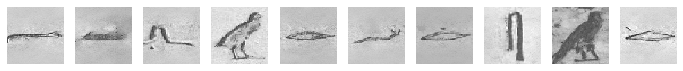

In [80]:
plots(test_imgs, figsize=(12,6), rows=1, interp=False, titles=None)

In [185]:
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size
model.evaluate_generator(generator=valid_batches,
steps=STEP_SIZE_VALID)

KeyboardInterrupt: 

In [202]:
STEP_SIZE_TEST=test_batches.n//test_batches.batch_size
test_generator.reset()
pred=model.predict_generator(test_batches,
steps=STEP_SIZE_TEST,
verbose=1)

543/543 [==============================] - 229s 423ms/step


In [203]:
predicted_class_indices=np.argmax(pred,axis=1)

In [204]:
labels = (train_batches.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [205]:
predictions

['D2',
 'D2',
 'D21',
 'D21',
 'D21',
 'D21',
 'D21',
 'D21',
 'D21',
 'D21',
 'D21',
 'D21',
 'D21',
 'D21',
 'D21',
 'E34',
 'D21',
 'D21',
 'D21',
 'D21',
 'D21',
 'D21',
 'D21',
 'D21',
 'D28',
 'D28',
 'D28',
 'D35',
 'D35',
 'D35',
 'D35',
 'D35',
 'D35',
 'D35',
 'D35',
 'D36',
 'D36',
 'D36',
 'D36',
 'D36',
 'D36',
 'I9',
 'D36',
 'D4',
 'D4',
 'D4',
 'D4',
 'D4',
 'X1',
 'D21',
 'D46',
 'I9',
 'D46',
 'D46',
 'D46',
 'D46',
 'G43',
 'X1',
 'D58',
 'D58',
 'D58',
 'D58',
 'D58',
 'D58',
 'X1',
 'V31',
 'E34',
 'E34',
 'E34',
 'E34',
 'D35',
 'E34',
 'D35',
 'E34',
 'E34',
 'E34',
 'E34',
 'E34',
 'E34',
 'E34',
 'E34',
 'E34',
 'G1',
 'G1',
 'G35',
 'G1',
 'G1',
 'G1',
 'G17',
 'G17',
 'G17',
 'G17',
 'G17',
 'G1',
 'G17',
 'G17',
 'G17',
 'G17',
 'G17',
 'G17',
 'G17',
 'G17',
 'G17',
 'G17',
 'G17',
 'G17',
 'G17',
 'G17',
 'G17',
 'G17',
 'G17',
 'G17',
 'G17',
 'G17',
 'G17',
 'G17',
 'G17',
 'G17',
 'G17',
 'G17',
 'G25',
 'G25',
 'G25',
 'G35',
 'G35',
 'G35',
 'G35',
 '

In [231]:
pred_df = pd.DataFrame(predictions, columns=['predicted'])
pred_df = pred_df.merge(pd.DataFrame(test_batches.filenames, columns=['filename']), left_index=True, right_index=True)
pred_df['glyph'] = pred_df.apply(lambda row: re.match(r'^([A-Z]{1}\d+)/', row['filename']).group(1), axis=1)
pred_df['match'] = pred_df['predicted'] == pred_df['glyph']
pred_df.head()

,predicted,filename,glyph,match
0,D2,D2/070242_D2.png,D2,True
1,D2,D2/220196_D2.png,D2,True
2,D21,D21/030269_D21.png,D21,True
3,D21,D21/030273_D21.png,D21,True
4,D21,D21/050286_D21.png,D21,True


In [232]:
acc = pred_df['match'].sum() / len(pred_df)
acc

0.9208103130755064

In [223]:
index = 0
image, label = test_batches._get_batches_of_transformed_samples(np.array([index]))
image_name = test_batches.filenames[index]

In [213]:
image_name

'D2/070242_D2.png'

In [225]:
label

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]], dtype=float32)

In [222]:
idx = np.arange(543)
image, label in test_batches._get_batches_of_transformed_samples(np.array(0))
# test_batches.filenames[idx]

TypeError: len() of unsized object

In [218]:
idx

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18